In [28]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [2]:
import pandas as pd 

In [3]:
df = pd.read_csv("../data/known.csv")

In [9]:
list(df)

['ID',
 'First_MAD',
 'SalOrg',
 'DC',
 'Ship_To',
 'ordre',
 'Plant',
 'Material',
 'ItemCat',
 'OrderQty',
 'LT',
 'LogABC',
 'MOQ',
 'ROP',
 'SafetyStk',
 'PL',
 'MktABC',
 'SubFct',
 'Gross_Weight',
 'Length',
 'Width',
 'Height',
 'Volume',
 'Gamma',
 'Manufacturer',
 'Business',
 'Month',
 'CBO_CBO_Qty_Shortage',
 'Age_ZN_ZI_years',
 'DP_FAMILY_CODE',
 'PRODUCT_STATUS',
 'ORIGINAL_SUPPLIER',
 'SUBRANGE',
 'Comp_reference_number',
 'Name_Of_Competitor',
 'COMP_PRICE_MIN',
 'COMP_PRICE_AVG',
 'COMP_PRICE_MAX',
 'PRICE',
 'NEAREST_COMP_PRICE_MIN',
 'NEAREST_COMP_PRICE_MAX']

In [13]:
dataset =  df[['SalOrg','Month', 'Material','OrderQty']].groupby(['SalOrg','Month', 'Material']).agg(sum)

In [15]:
# fix random seed for reproducibility
numpy.random.seed(7)


In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [17]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

611276 301077


In [18]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [19]:

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [20]:

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [29]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=100000, verbose=2)

Epoch 1/100
2s - loss: 0.0037
Epoch 2/100
0s - loss: 0.0035
Epoch 3/100
1s - loss: 0.0034
Epoch 4/100
1s - loss: 0.0034
Epoch 5/100
1s - loss: 0.0034
Epoch 6/100
1s - loss: 0.0034
Epoch 7/100
1s - loss: 0.0033
Epoch 8/100
1s - loss: 0.0033
Epoch 9/100
1s - loss: 0.0033
Epoch 10/100
1s - loss: 0.0033
Epoch 11/100
1s - loss: 0.0033
Epoch 12/100
0s - loss: 0.0033
Epoch 13/100
1s - loss: 0.0032
Epoch 14/100
1s - loss: 0.0032
Epoch 15/100
1s - loss: 0.0032
Epoch 16/100
1s - loss: 0.0032
Epoch 17/100
0s - loss: 0.0032
Epoch 18/100
0s - loss: 0.0032
Epoch 19/100
0s - loss: 0.0032
Epoch 20/100
0s - loss: 0.0031
Epoch 21/100
0s - loss: 0.0031
Epoch 22/100
1s - loss: 0.0031
Epoch 23/100
1s - loss: 0.0031
Epoch 24/100
0s - loss: 0.0031
Epoch 25/100
1s - loss: 0.0031
Epoch 26/100
1s - loss: 0.0031
Epoch 27/100
0s - loss: 0.0031
Epoch 28/100
0s - loss: 0.0031
Epoch 29/100
0s - loss: 0.0031
Epoch 30/100
0s - loss: 0.0031
Epoch 31/100
0s - loss: 0.0031
Epoch 32/100
0s - loss: 0.0031
Epoch 33/100
0s -

In [30]:


# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_absolute_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f MAE' % (trainScore))
testScore = math.sqrt(mean_absolute_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f MAE' % (testScore))


Train Score: 6.45 MAE
Test Score: 6.99 MAE


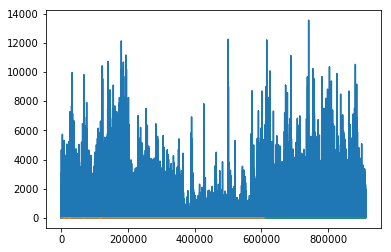

In [31]:

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [33]:
unknown = pd.read_csv('../data/unknown.csv')

In [43]:
list(unknown)

['ID', 'SalOrg', 'Material', 'date']

In [45]:
unknown.rename({'date': 'Month'})

,ID,SalOrg,Material,date
0,0,97LK,00IYcj,2017-04
1,1,97LK,00lqzT,2017-04
2,2,97LK,00MFcK,2017-04
3,3,97LK,00mt9e,2017-04
4,4,97LK,00Ok8y,2017-04
5,5,97LK,00W03x,2017-04
6,6,97LK,02jRc8,2017-04
7,7,97LK,02QhQT,2017-04
8,8,97LK,0355Np,2017-04
9,9,97LK,03eCyI,2017-04


In [47]:
testPredict = model.predict(unknown[['SalOrg','Material']])

ValueError: Error when checking : expected lstm_8_input to have 3 dimensions, but got array with shape (116028, 2)